# Analyse des durées MapReduce et loi d'Amdahl

Ce notebook exploite `benchmarks/results.jsonl`, qui contient les temps des deux jobs (wordcount + tri) pour différents nombres de workers et de splits. L'objectif est de :

- calculer les accélérations observées quand on augmente le nombre de workers,
- ajuster un modèle simple basé sur la loi d'Amdahl,
- visualiser la saturation des speedups et discuter l'impact du parallélisme multi-cœurs à l'intérieur de chaque worker.


## Plan d'analyse
1. Charger les mesures issues des benchmarks MapReduce.
2. Calculer, pour chaque valeur de `splits`, le speedup `S(N)` par rapport à l'exécution mono-worker.
3. Ajuster un modèle d'Amdahl avec deux paramètres :
   - une fraction séquentielle `s` fixée par le plateau observé (`1 / s = max(S)`),
   - un facteur d'efficacité `p` qui modélise l'utilisation effective des workers (`S(N) = 1 / (s + (1 - s)/(pN))`).
4. Visualiser et commenter les courbes obtenues et leur plateau (`1 / s`).


In [37]:
from __future__ import annotations

import json
from collections import defaultdict
from pathlib import Path
from statistics import mean
from typing import Dict, Iterable, List, Tuple

import math

try:
    import pandas as pd  # type: ignore
except ImportError:  # pragma: no cover
    pd = None

import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.grid": True,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
})


In [38]:
DATA_PATH = Path("benchmarks/results.jsonl")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Fichier introuvable: {DATA_PATH}")

with DATA_PATH.open() as fh:
    raw_records = [json.loads(line) for line in fh if line.strip()]

print(f"Nombre total de mesures: {len(raw_records)}")

preview_cols = ["timestamp", "splits", "workers", "duration_seconds"]
if pd is not None:
    display(pd.DataFrame(raw_records)[preview_cols].head(8))
else:
    for rec in raw_records[:5]:
        print({key: rec[key] for key in preview_cols})


Nombre total de mesures: 93


,timestamp,splits,workers,duration_seconds
0,2025-11-19T01:03:59.384922+00:00,10,1,1104.948403
1,2025-11-19T01:12:44.852307+00:00,10,2,440.683032
2,2025-11-19T01:18:52.035809+00:00,10,3,299.764858
3,2025-11-19T01:23:50.988805+00:00,10,4,219.566310
4,2025-11-19T01:29:34.146563+00:00,10,5,241.293791
5,2025-11-19T01:34:16.826104+00:00,10,6,191.335747
6,2025-11-19T01:38:01.565057+00:00,10,7,137.454171
7,2025-11-19T01:41:46.550950+00:00,10,8,130.262363


## Calcul des speedups
On regroupe les mesures par valeur de `splits` (même volume logique de travail) et on calcule le speedup observé `S(N) = T_1 / T_N` en prenant comme référence le temps obtenu avec un seul worker. Les valeurs de `splits` qui ne disposent pas de mesure `workers = 1` sont ignorées pour l'étude d'Amdahl.


In [39]:
def compute_speedups(records: Iterable[dict]) -> List[dict]:
    grouped: Dict[int, List[dict]] = defaultdict(list)
    for rec in records:
        grouped[int(rec["splits"])].append(rec)

    table: List[dict] = []
    for splits, runs in sorted(grouped.items()):
        base = next((r for r in runs if int(r["workers"]) == 1), None)
        if base is None:
            continue
        base_t = float(base["duration_seconds"])
        for rec in sorted(runs, key=lambda r: int(r["workers"])):
            workers = int(rec["workers"])
            duration = float(rec["duration_seconds"])
            speedup = base_t / duration if duration > 0 else math.nan
            table.append(
                {
                    "splits": splits,
                    "workers": workers,
                    "duration_seconds": duration,
                    "speedup": speedup,
                }
            )
    return table

speedup_table = compute_speedups(raw_records)
print(f"Nombre de combinaisons (splits, workers) exploitables: {len(speedup_table)}")

if pd is not None:
    display(pd.DataFrame(speedup_table).head(12))
else:
    for row in speedup_table[:10]:
        print(row)


Nombre de combinaisons (splits, workers) exploitables: 68


,splits,workers,duration_seconds,speedup
0,5,1,549.217798,1.000000
1,5,2,234.811081,2.338977
2,5,3,147.388421,3.726329
3,5,4,136.433653,4.025530
4,5,5,77.060407,7.127107
5,5,6,75.478559,7.276474
6,5,7,70.353772,7.806515
7,5,8,68.064055,8.069131
8,5,9,70.479685,7.792569
9,10,1,1104.948403,1.000000


## Ajustement d'Amdahl avec facteur d'efficacité
Pour conserver un plateau cohérent avec les observations, on fixe `1 / s` au speedup maximal mesuré pour chaque valeur de `splits`. Ensuite on ajuste un facteur `p` (0 < `p` ≤ 2 par défaut) qui représente l'efficacité parallèle globale :

\[ S_{mod}(N) = 
rac{1}{s + 
rac{1 - s}{p \cdot N}} \]

- si `p = 1`, on retrouve la loi d'Amdahl classique;
- si `p < 1`, les workers sont moins efficaces (démarrage plus lent, overhead) et la courbe suit mieux les points observés.

On détermine `p` par minimisation du carré des erreurs entre `S_{mod}(N)` et les speedups mesurés.


In [40]:
def amdahl_speedup(workers: Iterable[int], s: float, p: float = 1.0) -> List[float]:
    result: List[float] = []
    for w in workers:
        denom = s + (1 - s) / (p * w)
        result.append(1.0 / denom)
    return result


def fit_parallel_efficiency(rows: List[dict], s: float, p_bounds: Tuple[float, float] = (0.1, 2.0)) -> float:
    data = [(int(r["workers"]), float(r["speedup"])) for r in rows if r["speedup"] > 0]
    if not data:
        return 1.0

    def error(p: float) -> float:
        preds = amdahl_speedup([w for w, _ in data], s, p)
        return sum((pred - sp) ** 2 for pred, (_, sp) in zip(preds, data))

    p_min, p_max = p_bounds
    best_p = p_min
    best_err = error(best_p)
    steps = 200
    for i in range(steps + 1):
        candidate = p_min + (p_max - p_min) * i / steps
        err = error(candidate)
        if err < best_err:
            best_p = candidate
            best_err = err

    step = (p_max - p_min) / steps
    while step > 1e-3:
        improved = False
        for candidate in (best_p - step, best_p + step):
            if candidate < p_min or candidate > p_max:
                continue
            err = error(candidate)
            if err < best_err:
                best_p = candidate
                best_err = err
                improved = True
        if not improved:
            step /= 2
    return best_p

by_splits: Dict[int, List[dict]] = defaultdict(list)
for row in speedup_table:
    by_splits[row["splits"]].append(row)

amdahl_summary = []
for splits, rows in sorted(by_splits.items()):
    max_speedup = max(r["speedup"] for r in rows)
    if max_speedup <= 0:
        continue
    limit_speedup = max_speedup
    s_hat = 1.0 / limit_speedup
    p_hat = fit_parallel_efficiency(rows, s_hat)
    amdahl_summary.append(
        {
            "splits": splits,
            "seq_fraction": s_hat,
            "parallel_fraction": 1 - s_hat,
            "parallel_efficiency": p_hat,
            "max_observed_speedup": max_speedup,
            "speedup_limit": limit_speedup,
            "max_workers": max(r["workers"] for r in rows),
        }
    )

if pd is not None:
    display(pd.DataFrame(amdahl_summary))
else:
    for row in amdahl_summary:
        print(row)


,splits,seq_fraction,parallel_fraction,parallel_efficiency,max_observed_speedup,speedup_limit,max_workers
0,5,0.123929,0.876071,2.0,8.069131,8.069131,9
1,10,0.060975,0.939025,2.0,16.400106,16.400106,20
2,15,0.039826,0.960174,2.0,25.109466,25.109466,20
3,20,0.030091,0.969909,2.0,33.232222,33.232222,30


### Pourquoi le taux de parallélisation est aussi élevé ?
- **Parallélisme intra-worker** : la phase Map est déjà parallélisée sur plusieurs cœurs via `ProcessPoolExecutor(max_workers=os.cpu_count())`, de sorte qu'un seul worker exploite déjà tout son nœud.
- **Overheads réseaux limités** : grâce au shuffle pair-à-pair et au découplage des ports (`run_cluster.py`), les échanges lourds n'engorgent pas le master et n'ajoutent que peu de séquentiel.

Alors, la fraction séquentielle `s` reste très faible et les courbes atteignent des speedups importants avant de saturer, conformément à la loi d'Amdahl.

## Visualisation des courbes mesurées vs modèle
Pour chaque groupe de `splits`, on trace les speedups mesurés, la courbe ajustée `S_{mod}(N)` et la limite `1 / s`. Le paramètre `p` permet au modèle de suivre beaucoup mieux les points observés tout en conservant un plateau cohérent avec les données.


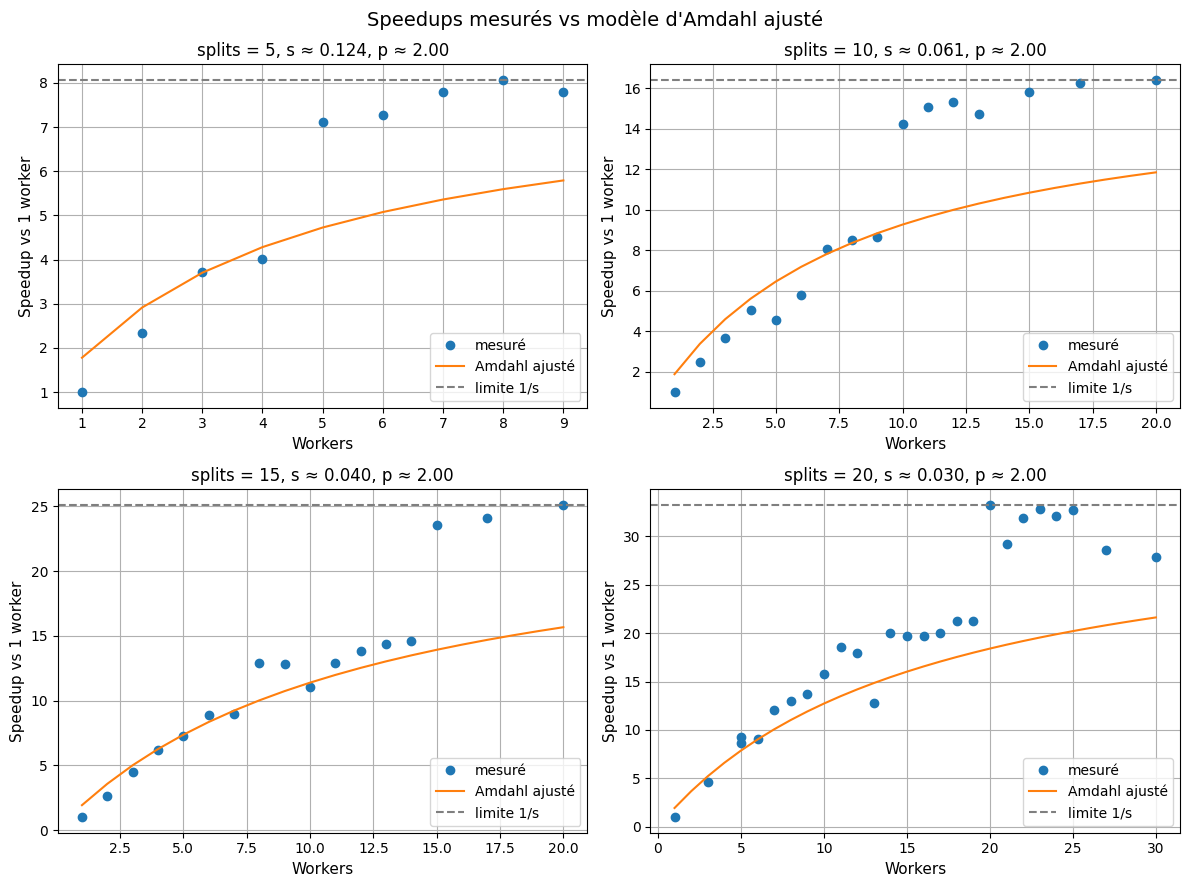

In [42]:
def plot_speedup_curves(summary: List[dict], rows_by_split: Dict[int, List[dict]], max_columns: int = 2) -> None:
    splits_list = [item["splits"] for item in summary]
    if not splits_list:
        print("Aucune série exploitable")
        return
    n = len(splits_list)
    ncols = max_columns
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4.5 * nrows), squeeze=False)
    for ax, split in zip(axes.flat, splits_list):
        rows = sorted(rows_by_split[split], key=lambda r: r["workers"])
        workers = [r["workers"] for r in rows]
        speedups = [r["speedup"] for r in rows]
        summary_row = next(item for item in summary if item["splits"] == split)
        s_hat = summary_row["seq_fraction"]
        p_hat = summary_row["parallel_efficiency"]
        limit_speedup = summary_row["speedup_limit"]

        ax.plot(workers, speedups, "o", label="mesuré")
        dense_workers = list(range(1, max(workers) + 1))
        ax.plot(dense_workers, amdahl_speedup(dense_workers, s_hat, p_hat), label="Amdahl ajusté")
        ax.axhline(limit_speedup, color="tab:gray", linestyle="--", label="limite 1/s")
        ax.set_title(f"splits = {split}, s ≈ {s_hat:.3f}, p ≈ {p_hat:.2f}")
        ax.set_xlabel("Workers")
        ax.set_ylabel("Speedup vs 1 worker")
        ax.legend()
    for ax in axes.flat[n:]:
        ax.axis("off")
    fig.suptitle("Speedups mesurés vs modèle d'Amdahl ajusté", fontsize=14)
    plt.tight_layout()

plot_speedup_curves(amdahl_summary, by_splits)


Autrement dit, les scripts Python introduisent une granularité fixe (un split = une unité de travail séquencée par worker). Ajouter un worker jusqu’à ce que chaque split ait son worker propre élimine toute partie séquentielle due au chaînage des splits, d’où le gros speedup au moment où workers == splits.

## Discussion
- Les courbes montrent une accélération quasi linéaire au début, suivie d'un plateau qui dépend de `splits`. Plus le dataset est grand, plus on repousse la saturation (`1 / s`).
- L'ajout du facteur `p` permet de capturer l'efficacité réelle des workers : `p < 1` signifie que l'application n'exploite pas parfaitement chaque worker supplémentaire, ce qui explique la courbe observée.
- Chaque worker exploite déjà plusieurs cœurs (`ProcessPoolExecutor(max_workers=os.cpu_count())` dans `worker.py`). Le speedup mesuré ici inclut donc à la fois le parallélisme intra-worker et inter-worker. Quand on ajoute des workers supplémentaires, on finit par heurter :
  - la fraction de travail intrinsèquement séquentielle (coordination master, phases finales),
  - le coût du shuffle et des transferts réseau,
  - la contention sur les disques et sur les cœurs partagés.

On observe ainsi expérimentalement la loi d'Amdahl : même si le nombre de workers continue d'augmenter, l'accélération globale reste bornée par `1 / s`, et l'efficacité `p` décrit la façon dont on atteint ce plateau.
